<a href="https://colab.research.google.com/github/jcuesta123/TFM-RL/blob/main/airplane_gust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORTS
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#General parametes
m_a = 1000 # kg
g = 9.81   # m/s2
l_a = 4 # m airplane length
S_w = 4 # m2 wing surface
S_t = S_w/4 # m2 tail wing surface
l_w = 0.5 # m wing_length
I_a = (1/12) * m_a * (l_a)**2
ro = 1 # kg/m3  air density
pi = math.pi

#State variables
x = 0       # m
z = 100     # m
v = 100     # m/s
gamma = 0   # rad
theta = 0   # rad
v_theta = 0 # rad/s
T = 1500 # N  thrust
EC = 0 # elevator control

alpha = theta - gamma

state = np.array([x, z, v, gamma, theta, v_theta, T, EC])

In [3]:
T_range = np.array([0, 0.3])*m_a*g   #trust up to 30% of weight
EC_range = np.array([-3, 3])*pi/180  # EC from -3º to 3º  ###OJO grados

In [4]:
#LIFT function
# v_tipic = 100 m/s,  5º or 0.087 rad -> 10 kN

C_L_alpha = 5.73 # coeficcient increase in C_L per radian, = 1CL per 10º
max_C_L_angle = 0.26 #rad, about 15º
C_L_alpha_zero = 0 #

def L(v, alpha, EC, gust):

  # OJO al entorno

  if gust == True:
    alpha += 0.11

  lift_w = 0.5 * ro * v**2 * S_w * (0.25 + 2.87 * alpha)
  lift_t = 0.5 * ro * v**2 * S_t * (0.00 + 5.73 * (alpha + EC))
  lift = lift_w + lift_t

  return lift, lift_w, lift_t

In [5]:
def D(v, alpha, EC, gust):

  if gust == True:
    alpha += 0.11
  C_D_w = 0.05 + 0.089 * (0.25 + 2.87 * alpha) **2
  C_D_t = 0.05 + 0.089 * (0.00 + 5.73 * (alpha + EC)) **2

  drag = 0.5 * ro * v**2 * (S_w * C_D_w + S_t * C_D_t)

  return drag

In [6]:
#plot graphics

def plot_traj(matrix_state):

  x = matrix_state[:, 0]
  z = matrix_state[:, 1]
  v = matrix_state[:, 2]
  gamma = matrix_state[:, 3]
  theta = matrix_state[:, 4]
  alpha = theta - gamma
  v_theta = matrix_state[:, 5]
  T = matrix_state[:, 6]
  EC = matrix_state[:, 7]
  t = matrix_state[:, 8]
  ep_reward = matrix_state[:, 9]
  v_z = matrix_state[:, 2] * np.sin(matrix_state[:, 3])

  plt.subplot(4, 2, 1)  # 2 filas, 1 columna, primera posición
  plt.plot(x, z)  # 'r--' indica línea roja discontinua
  plt.title('Trayectory (m)')
  plt.xlabel('Axis X')
  plt.ylabel('Axis Y')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(0, color='black', linewidth=0.5)

  plt.subplot(4, 2, 2)  # 2 filas, 1 columna, primera posición
  plt.plot(t, v,'-.')  # 'r--' indica línea roja discontinua
  plt.title('Absolute Velocity (m/s)')
  plt.grid(True)

  plt.subplot(4, 2, 3)  # 2 filas, 1 columna, primera posición
  plt.plot(t, v_theta*180/pi,'-.')  # 'r--' indica línea roja discontinua
  plt.title('Angular velocity (º/s)')
  plt.grid(True)

  plt.subplot(4, 2, 4)  # 2 filas, 1 columna, primera posición
  plt.plot(t, gamma*180/pi, color='red')#, label='gamma (red)')  # 'r--' indica línea roja discontinua
  plt.plot(t, theta*180/pi, color='green')#, label='theta (green)')  # 'r--' indica línea roja discontinua
  plt.plot(t, alpha*180/pi, color='blue')#, label='alpha (blue)')  # 'r--' indica línea roja discontinua
  plt.legend()
  plt.title('Angles (º)')
  plt.grid(True)
  plt.tight_layout()

  plt.subplot(4, 2, 5)  # 2 filas, 1 columna, primera posición
  plt.plot(t, T)  # 'r--' indica línea roja discontinua
  plt.title('T (N)')
  plt.grid(True)

  plt.subplot(4, 2, 6)  # 2 filas, 1 columna, primera posición
  plt.plot(t, EC*180/pi)  # 'r--' indica línea roja discontinua
  plt.title('EC (º)')
  plt.grid(True)

  plt.subplot(4, 2, 7)  # 2 filas, 1 columna, primera posición
  plt.plot(t, ep_reward)  # 'r--' indica línea roja discontinua
  plt.title('Ep. reward')
  plt.grid(True)

  plt.subplot(4, 2, 8)  # 2 filas, 1 columna, primera posición
  plt.plot(t, v_z)  # 'r--' indica línea roja discontinua
  plt.title('Vertical speed (m/s)')
  plt.grid(True)


  plt.show()

In [7]:
def environment(state, action,gust):

  x,z,v,gamma,theta,v_theta,T, EC = state
  alpha = theta - gamma #####   #########   #####  ###########  OJO al orden
  lift, lift_w, lift_t = L(v,alpha,EC,gust)
  drag = D(v,alpha,EC,gust)

  #PROCESSING ACTION
  if action == 1 and T <= T_range[1]:
    T += T_range[1]/10
  elif action == 2 and T >= T_range[0]:
    T -= T_range[1]/10
  elif action == 3 and EC <= EC_range[1]:
    EC += EC_range[1]/10
  elif action == 4 and EC >= EC_range[0]:
    EC -= EC_range[1]/10
  else: #action == 0   do nothing
    pass


  #forces
  a_x = (1/m_a) * (T * math.cos(theta) - drag * math.cos(gamma) - lift * math.sin(theta))
  a_z = (1/m_a) * (T * math.sin(theta) - drag * math.sin(gamma) + lift * math.cos(theta) - m_a * g)
  a_theta = (1/I_a) * (l_w * lift_w - l_t * lift_t)

  v_x = v * math.cos(gamma) + a_x * deltaT
  v_z = v * math.sin(gamma) + a_z * deltaT
  v_theta = v_theta + a_theta * deltaT

  x = x + v_x * deltaT
  z = z + v_z * deltaT
  theta = theta + v_theta * deltaT

  v = math.sqrt(v_x ** 2 + v_z ** 2)
  gamma = math.atan2(v_z, v_x)

  next_state = np.array([x, z, v, gamma, theta, v_theta, T, EC])

  # call reward function
  reward = reward_function(next_state, done)

  return next_state, reward, done

In [30]:
def reward_function(state, done):

  reward = 0

  #reward += deltaT * (10 - abs(state[1] - 1000))

  reward += (20 / (1 + abs(state[1] - 1000))) * deltaT

  if (state[1] - 1000) * state[3] < 0:
    reward += 2 * deltaT
  else:
    reward += -1 * deltaT

  return reward

In [9]:
num_features = state.size
num_actions = 5
random.randint(0, num_actions-1)

#NEURONAL NETWORKS

class DQN(nn.Module):
    """Dense neural network class."""
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 64)
        self.fc2 = nn.Linear(64, 128)
        self.out = nn.Linear(128, num_actions)

    def forward(self, states):
        """Forward pass."""
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        return self.out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_nn = DQN(num_features, num_actions).to(device)
target_nn = DQN(num_features, num_actions).to(device)

optimizer = torch.optim.Adam(main_nn.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

print(device)

cpu


In [10]:
#BUFFER MEMORY

class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size, device="cpu"):
    """Initializes the buffer."""
    self.buffer = deque(maxlen=size)
    self.device = device

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = torch.as_tensor(np.array(states), device=self.device)
    actions = torch.as_tensor(np.array(actions), device=self.device)
    rewards = torch.as_tensor(np.array(rewards, dtype=np.float32), device=self.device
    )
    next_states = torch.as_tensor(np.array(next_states), device=self.device)
    dones = torch.as_tensor(np.array(dones, dtype=np.float32), device=self.device)
    return states, actions, rewards, next_states, dones

In [11]:
#TRAIN FUNCTION

def train_step(states, actions, rewards, next_states, dones):

  max_next_qs = target_nn(next_states).max(-1).values
  target = rewards + (1.0 - dones) * discount * max_next_qs
  qs = main_nn(states)
  action_masks = F.one_hot(actions, num_actions)
  masked_qs = (action_masks * qs).sum(dim=-1)
  loss = loss_fn(masked_qs, target.detach())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [12]:
#ACTION

def select_action(state, epsilon):

  #return 0

  result = np.random.uniform()

  if result < epsilon:
    return random.randint(0, num_actions-1)   #random action
  else:
    qs = main_nn(state).cpu().data.numpy()    #NN action
    return np.argmax(qs)


In [13]:
print(state)

[   0  100  100    0    0    0 1500    0]


In [33]:
#TRAINING LOOP

# Hyperparameters.
num_episodes = 200  #IMPORTANT
epsilon = 1.0
batch_size = 32
discount = 0.99
buffer = ReplayBuffer(100000, device=device)
last_100_ep_rewards = []

deltaT = 0.01
l_t = l_w * 4

initial_state = np.array([0, 1000, 88, 0, 0.087, 0, 2250, 0]) #x,z,v,gamma,theta,v_theta,T
gust = False

for episode in range(num_episodes+1):
  state = initial_state.astype(np.float32)
  cur_frame = 0
  ep_reward = 0
  done = False
  time = 0

  for i in range(3000):

    state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
    action = select_action(state_in, epsilon)
    next_state, reward, done = environment(state, action, gust)
    next_state = next_state.astype(np.float32)
    ep_reward += reward

    #save experience
    buffer.add(state, action, reward, next_state, done)
    state = next_state
    cur_frame += 1

    #copy main_nn weights to target_nn.
    if cur_frame % 2000 == 0:
      target_nn.load_state_dict(main_nn.state_dict())

    #train neural network.
    if len(buffer) > batch_size:
      states, actions, rewards, next_states, dones = buffer.sample(batch_size)
      loss = train_step(states, actions, rewards, next_states, dones)

  #epsilon decresases each episode
  if epsilon > 0.05:
    epsilon -= 0.95/num_episodes

  if len(last_100_ep_rewards) == 100:
    last_100_ep_rewards = last_100_ep_rewards[1:]
  last_100_ep_rewards.append(ep_reward)

  #printing training progress
  if episode % 10 == 0:
    print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}.'
          f' Reward in last 100 episodes: {np.mean(last_100_ep_rewards):.2f}')


Episode 0/200. Epsilon: 0.995. Reward in last 100 episodes: 35.68
Episode 10/200. Epsilon: 0.948. Reward in last 100 episodes: 42.36
Episode 20/200. Epsilon: 0.900. Reward in last 100 episodes: 50.57
Episode 30/200. Epsilon: 0.853. Reward in last 100 episodes: 48.35
Episode 40/200. Epsilon: 0.805. Reward in last 100 episodes: 47.63
Episode 50/200. Epsilon: 0.758. Reward in last 100 episodes: 44.14
Episode 60/200. Epsilon: 0.710. Reward in last 100 episodes: 50.26
Episode 70/200. Epsilon: 0.663. Reward in last 100 episodes: 52.97
Episode 80/200. Epsilon: 0.615. Reward in last 100 episodes: 54.33
Episode 90/200. Epsilon: 0.568. Reward in last 100 episodes: 56.76
Episode 100/200. Epsilon: 0.520. Reward in last 100 episodes: 57.51
Episode 110/200. Epsilon: 0.473. Reward in last 100 episodes: 58.50
Episode 120/200. Epsilon: 0.425. Reward in last 100 episodes: 58.00
Episode 130/200. Epsilon: 0.378. Reward in last 100 episodes: 59.78
Episode 140/200. Epsilon: 0.330. Reward in last 100 episode

11.083332598254058
983.4735


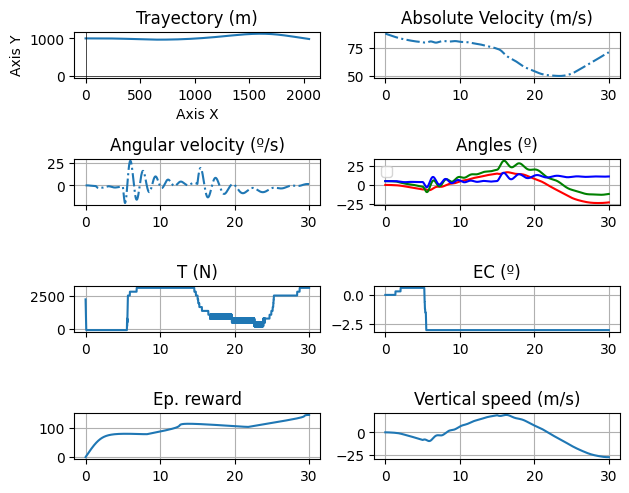

In [34]:
deltaT = 0.01
l_t = l_w * 4



initial_state = np.array([0, 1000, 88, 0, 0.087, 0, 2250, 0]) #x,z,v,gamma,theta,v_theta,T
state = initial_state.astype(np.float32)

time = 0
ep_reward = 0
done = False
gust = False

matrix_info = np.concatenate((state, [time], [ep_reward]))
cur_frame = 0

for i in range(3000):

  if 500 < i < 1500:
    gust = True
  else:
    gust = False

  state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
  action = select_action(state_in, 0)
  next_state, reward, done = environment(state, action, gust)
  next_state = next_state.astype(np.float32)
  ep_reward += reward

  ep_reward += reward
  time = deltaT * cur_frame

  matrix_info = np.vstack([matrix_info, np.concatenate((state, [time],  [ep_reward]))])

  state = next_state
  cur_frame += 1

print((state[4]-state[3])*180/pi)
print(state[1])
plot_traj(matrix_info)

In [35]:
#ACTION

def Mselect_action(state, epsilon):
  return 0



5.030244785964923
1139.1902


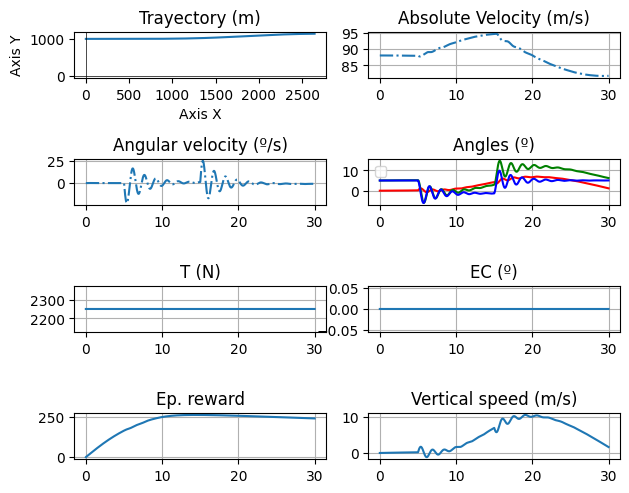

In [36]:
deltaT = 0.01
l_t = l_w * 4



initial_state = np.array([0, 1000, 88, 0, 0.087, 0, 2250, 0]) #x,z,v,gamma,theta,v_theta,T
state = initial_state.astype(np.float32)

time = 0
ep_reward = 0
done = False
gust = False

matrix_info = np.concatenate((state, [time], [ep_reward]))
cur_frame = 0

for i in range(3000):

  if 500 < i < 1500:
    gust = True
  else:
    gust = False

  state_in = torch.from_numpy(np.expand_dims(state, axis=0)).to(device)
  action = Mselect_action(state_in, 0)
  next_state, reward, done = environment(state, action, gust)
  next_state = next_state.astype(np.float32)
  ep_reward += reward

  ep_reward += reward
  time = deltaT * cur_frame

  matrix_info = np.vstack([matrix_info, np.concatenate((state, [time],  [ep_reward]))])

  state = next_state
  cur_frame += 1

print((state[4]-state[3])*180/pi)
print(state[1])
plot_traj(matrix_info)